# PCA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [2]:
train = pd.read_csv("data/data.csv")

In [3]:
test = pd.read_csv("data/test.csv")

## YearBuilt与SalePrice的关系
- YearBuilt 建筑年代(1872-2010;中位数1973；均值1971.27)
- 看起来最近建造的房屋的价格更高。所以后面使用labelencoder获得三个"Year"特征。

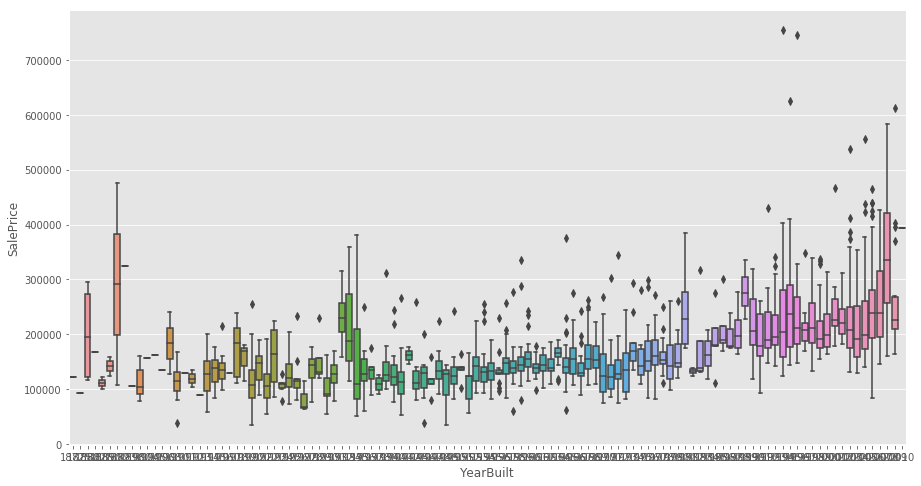

In [4]:
plt.figure(figsize=(15,8))
sns.boxplot(train.YearBuilt, train.SalePrice)

## 噪声
- GrLivArea：Above grade (ground) living area square feet，地面以上生活区的面积（平方英尺）。
- 我们可以看到其他GrLivArea与SalePrice整体是正相关的。不过，正如其他kernels中所讨论的那样，右下角两个具有极大GrLivArea的点可能是异常值。所以，删除它们！
- 这里是分析相关性得出的结论

(0, 800000)

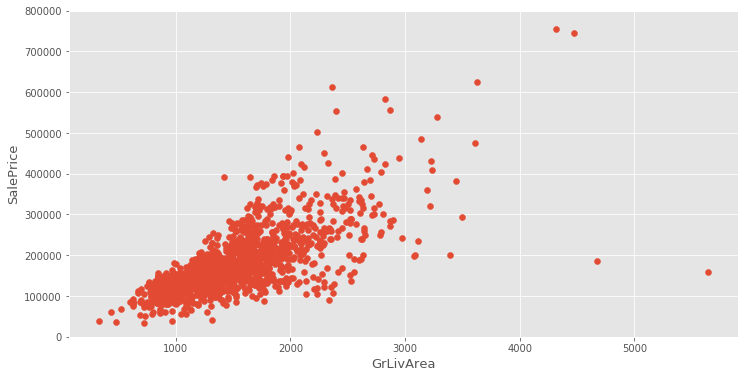

In [5]:
# 去掉噪声
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

In [ ]:
train.drop(train[(train["GrLivArea"]>4000) & (train["SalePrice"]<300000)].index, inplace=True)

(0, 800000)

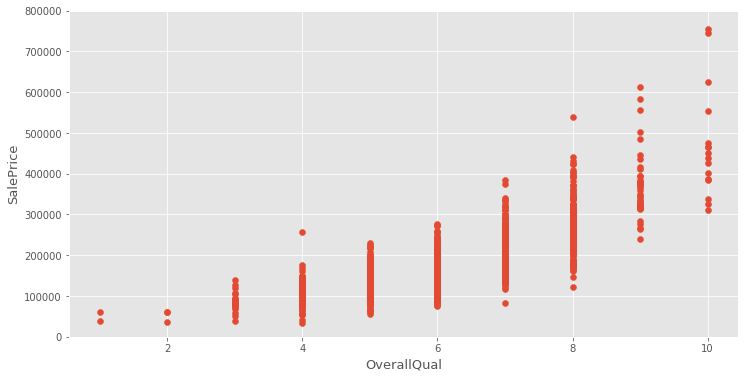

In [28]:
#OverallQual
# 去掉噪声
plt.figure(figsize=(12,6))
plt.scatter(x=train.OverallQual, y=train.SalePrice)
plt.xlabel("OverallQual", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

In [6]:
train.drop(train[(train["OverallQual"]<5) & (train["SalePrice"]>200000)].index, inplace=True)

In [7]:
# 将测试集和训练集合并在一起
data = pd.concat([train,test], ignore_index=True)

In [8]:
data.shape

(2917, 81)

In [9]:
data.drop(['Id'],axis=1, inplace=True)

In [10]:
data.shape

(2917, 80)

## 数据清洗

In [11]:
# 过滤数据集中各特征列含有的空值，按照空值数量降序排列
def getnullcount():
    x = data.isnull().sum()
    print(x[x>0].sort_values(ascending=False))
    x[x>0].sort_values(ascending=False).plot.bar()

In [35]:
x = data.isnull().sum()
have_nan_feature = x[x>0]
nan_columns = [i for i in have_nan_feature.index]
nan_columns

['Alley',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtQual',
 'BsmtUnfSF',
 'Electrical',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'FireplaceQu',
 'Functional',
 'GarageArea',
 'GarageCars',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'GarageYrBlt',
 'KitchenQual',
 'LotFrontage',
 'MSZoning',
 'MasVnrArea',
 'MasVnrType',
 'MiscFeature',
 'PoolQC',
 'SalePrice',
 'SaleType',
 'TotalBsmtSF',
 'Utilities']

In [63]:
def null_feature_analysis():
    Odic = {}
    Fdic = {}
    for col in nan_columns:
        # 数据类型
        dtype = data[col].dtype
        # 缺失数目
        nullNum = data[col].isnull().sum()
        # 类别数
        classNum = len(data.groupby([col])[col].head())
        li = [dtype, nullNum, classNum]
        if data[col].dtype == "float64": 
            Fdic[col] = li
        if data[col].dtype == "O":
            Odic[col] = li
    return Odic, Fdic

In [64]:
odic, fdic = null_feature_analysis()

In [65]:
odic

{'Alley': [dtype('O'), 2719, 15],
 'BsmtCond': [dtype('O'), 82, 25],
 'BsmtExposure': [dtype('O'), 82, 25],
 'BsmtFinType1': [dtype('O'), 79, 35],
 'BsmtFinType2': [dtype('O'), 80, 35],
 'BsmtQual': [dtype('O'), 81, 25],
 'Electrical': [dtype('O'), 1, 22],
 'Exterior1st': [dtype('O'), 1, 63],
 'Exterior2nd': [dtype('O'), 1, 74],
 'Fence': [dtype('O'), 2346, 25],
 'FireplaceQu': [dtype('O'), 1420, 30],
 'Functional': [dtype('O'), 2, 34],
 'GarageCond': [dtype('O'), 159, 28],
 'GarageFinish': [dtype('O'), 159, 20],
 'GarageQual': [dtype('O'), 159, 28],
 'GarageType': [dtype('O'), 157, 35],
 'KitchenQual': [dtype('O'), 1, 21],
 'MSZoning': [dtype('O'), 4, 29],
 'MasVnrType': [dtype('O'), 24, 25],
 'MiscFeature': [dtype('O'), 2812, 20],
 'PoolQC': [dtype('O'), 2908, 14],
 'SaleType': [dtype('O'), 1, 46],
 'Utilities': [dtype('O'), 2, 8]}

In [66]:
fdic

{'BsmtFinSF1': [dtype('float64'), 1, 1916],
 'BsmtFinSF2': [dtype('float64'), 1, 353],
 'BsmtFullBath': [dtype('float64'), 2, 19],
 'BsmtHalfBath': [dtype('float64'), 2, 16],
 'BsmtUnfSF': [dtype('float64'), 1, 2482],
 'GarageArea': [dtype('float64'), 1, 1589],
 'GarageCars': [dtype('float64'), 1, 27],
 'GarageYrBlt': [dtype('float64'), 159, 474],
 'LotFrontage': [dtype('float64'), 9, 536],
 'MasVnrArea': [dtype('float64'), 23, 1012],
 'SalePrice': [dtype('float64'), 1459, 1270],
 'TotalBsmtSF': [dtype('float64'), 1, 2326]}

In [45]:
data['GarageType'].isnull().sum()

157

In [52]:
len(data.groupby(['GarageArea'])['GarageArea'].head())

1589

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64


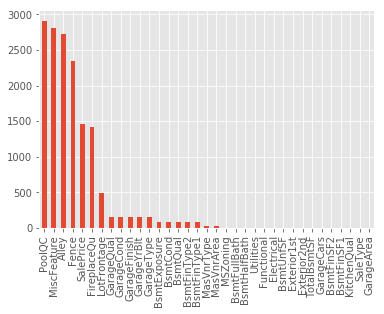

In [12]:
getnullcount()

- 让我们首先根据LotArea（地块面积）和Neighborhood的中位数输入LotFrontage的缺失值。 由于LotArea是一个连续的特征，我们使用qcut将它分成10个部分。
- LotArea：我理解为地块面积，地皮面积等，应该面积越大越贵。
- Neighborhood：表示房屋所处市区的位置（可理解为房子近邻区域），这个必选啊，合不合适在后面再具体分析。
- LotFrontage：临街面; 临海或临路部分的土地; 临街地界; 正面宽度; 屋向; 前方; 正面; 临街地。
- 填充的思路
    - （1）思路一：填不同的Neighborhood的均值和中位数
    - （2）思路二：通过LotArea进行填充，分析Lotfrontage与LotArea相关性

In [13]:
data.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.900000   43.0    20
Blueste        27.300000   24.0    10
BrDale         21.500000   21.0    30
BrkSide        55.789474   51.0    95
ClearCr        88.150000   80.5    20
CollgCr        71.336364   70.0   220
Crawfor        69.951807   70.0    83
Edwards        65.153409   64.5   176
Gilbert        74.207207   64.0   111
IDOTRR         62.241379   60.0    87
MeadowV        25.606061   21.0    33
Mitchel        75.144444   74.0    90
NAmes          75.210667   73.0   375
NPkVill        28.142857   24.0    21
NWAmes         81.517647   80.0    85
NoRidge        91.629630   89.0    54
NridgHt        84.184049   92.0   163
OldTown        61.777293   60.0   229
SWISU          59.068182   60.0    44
Sawyer         74.551020   72.0    98
SawyerW        70.669811   67.0   106
Somerst        64.549383   72.5   162
StoneBr        62.173913   60.0    46
Timber         81.157895   82.0    57
Veenker        72.000000   80.0    16

In [14]:
data["LotAreaCut"] = pd.qcut(data.LotArea,10)    # 新增一列，按照LotArea均分为10等份

In [15]:
data.groupby(['LotAreaCut'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 4921.8]    35.741036   34.0   251
(4921.8, 7007.2]      55.460674   52.0   267
(7007.2, 7949.0]      62.959839   62.0   249
(7949.0, 8740.4]      67.113725   65.0   255
(8740.4, 9452.0]      69.959184   70.0   245
(9452.0, 10148.8]     73.988235   75.0   255
(10148.8, 11000.0]    73.636364   75.0   253
(11000.0, 12196.8]    83.371681   82.0   226
(12196.8, 14285.8]    84.973684   85.0   228
(14285.8, 215245.0]   92.846535   90.0   202

In [23]:
# 
data.groupby(['LotAreaCut', 'Neighborhood']).head(2)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,LotAreaCut
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,0,Pave,8,856.0,AllPub,0,2003,2003,2008,"(7949.0, 8740.4]"
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,0,Pave,6,1262.0,AllPub,298,1976,1976,2007,"(9452.0, 10148.8]"
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,0,Pave,6,920.0,AllPub,0,2001,2002,2008,"(11000.0, 12196.8]"
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,0,Pave,7,756.0,AllPub,0,1915,1970,2006,"(9452.0, 10148.8]"
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,0,Pave,9,1145.0,AllPub,192,2000,2000,2008,"(12196.8, 14285.8]"
5,796,566,320,NaN,1,1Fam,TA,No,732.0,0.0,...,0,Pave,5,796.0,AllPub,40,1993,1995,2009,"(12196.8, 14285.8]"
6,1694,0,0,NaN,3,1Fam,TA,Av,1369.0,0.0,...,0,Pave,7,1686.0,AllPub,255,2004,2005,2007,"(9452.0, 10148.8]"
7,1107,983,0,NaN,3,1Fam,TA,Mn,859.0,32.0,...,0,Pave,7,1107.0,AllPub,235,1973,1973,2009,"(10148.8, 11000.0]"
8,1022,752,0,NaN,2,1Fam,TA,No,0.0,0.0,...,0,Pave,8,952.0,AllPub,90,1931,1950,2008,"(4921.8, 7007.2]"
9,1077,0,0,NaN,2,2fmCon,TA,No,851.0,0.0,...,0,Pave,5,991.0,AllPub,0,1939,1950,2008,"(7007.2, 7949.0]"


In [19]:
# df.transform(lambda x: x+1) 对df中的每一个元素都做+1的操作；
# df.groupby(['LotAreaCut', 'Neighborhood']) 先按照LotAreaCut分组，再按照Neighborhood分组
data['LotFrontage'] = data.groupby(['LotAreaCut', 'Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [20]:
# 由于LotArea和Neighborhood的某些组合不可用，所以我们只使用LotAreaCut。?
data['LotFrontage']=data.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

- 然后我们根据data_description填写其他缺失值。

In [24]:
data.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,2917.000000,2917.000000,2917.000000,2917.000000,2916.000000,2916.000000,2915.000000,2915.000000,2916.000000,2917.000000,...,2917.000000,2917.000000,1458.000000,2917.000000,2917.000000,2916.000000,2917.000000,2917.000000,2917.000000,2917.000000
mean,1157.692492,335.861502,2.604045,2.860130,439.015432,49.616255,0.429160,0.061407,560.695816,23.114158,...,6.086390,2.088790,180932.919067,16.073363,6.448063,1049.327503,93.629414,1971.287967,1984.248200,2007.792938
std,385.264298,428.119663,25.196714,0.822967,444.182329,169.258662,0.524002,0.245766,439.651650,64.263424,...,1.406704,34.561371,79495.055285,56.202054,1.564281,429.105905,126.532643,30.286991,20.892257,1.315328
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,34900.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,1950.000000,2006.000000
25%,876.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,220.000000,0.000000,...,5.000000,0.000000,129925.000000,0.000000,5.000000,793.000000,0.000000,1953.000000,1965.000000,2007.000000
50%,1082.000000,0.000000,0.000000,3.000000,368.000000,0.000000,0.000000,0.000000,467.000000,0.000000,...,6.000000,0.000000,163000.000000,0.000000,6.000000,988.500000,0.000000,1973.000000,1993.000000,2008.000000
75%,1384.000000,704.000000,0.000000,3.000000,733.000000,0.000000,1.000000,0.000000,804.500000,0.000000,...,7.000000,0.000000,214000.000000,0.000000,7.000000,1302.000000,168.000000,2001.000000,2004.000000,2009.000000
max,5095.000000,2065.000000,508.000000,8.000000,4010.000000,1526.000000,3.000000,2.000000,2336.000000,1012.000000,...,10.000000,800.000000,755000.000000,576.000000,15.000000,5095.000000,1424.000000,2010.000000,2010.000000,2010.000000


In [25]:
len(data.columns)

81

In [67]:
fdic

{'BsmtFinSF1': [dtype('float64'), 1, 1916],
 'BsmtFinSF2': [dtype('float64'), 1, 353],
 'BsmtFullBath': [dtype('float64'), 2, 19],
 'BsmtHalfBath': [dtype('float64'), 2, 16],
 'BsmtUnfSF': [dtype('float64'), 1, 2482],
 'GarageArea': [dtype('float64'), 1, 1589],
 'GarageCars': [dtype('float64'), 1, 27],
 'GarageYrBlt': [dtype('float64'), 159, 474],
 'LotFrontage': [dtype('float64'), 9, 536],
 'MasVnrArea': [dtype('float64'), 23, 1012],
 'SalePrice': [dtype('float64'), 1459, 1270],
 'TotalBsmtSF': [dtype('float64'), 1, 2326]}

In [68]:
cols = ["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    data[col].fillna(0, inplace=True)

In [71]:
[i for i in fdic if i not in cols]

['BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'LotFrontage', 'SalePrice']

In [72]:
data.GarageCars

0       2.0
1       2.0
2       2.0
3       3.0
4       3.0
5       2.0
6       2.0
7       2.0
8       2.0
9       1.0
10      1.0
11      3.0
12      1.0
13      3.0
14      1.0
15      2.0
16      2.0
17      2.0
18      2.0
19      1.0
20      3.0
21      1.0
22      2.0
23      2.0
24      1.0
25      3.0
26      2.0
27      3.0
28      1.0
29      1.0
       ... 
2887    1.0
2888    1.0
2889    0.0
2890    0.0
2891    0.0
2892    2.0
2893    2.0
2894    2.0
2895    2.0
2896    2.0
2897    2.0
2898    2.0
2899    2.0
2900    3.0
2901    3.0
2902    1.0
2903    4.0
2904    1.0
2905    1.0
2906    3.0
2907    0.0
2908    1.0
2909    1.0
2910    1.0
2911    0.0
2912    0.0
2913    1.0
2914    2.0
2915    0.0
2916    3.0
Name: GarageCars, Length: 2917, dtype: float64

In [74]:
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    data[col].fillna("None", inplace=True)

In [73]:
odic

{'Alley': [dtype('O'), 2719, 15],
 'BsmtCond': [dtype('O'), 82, 25],
 'BsmtExposure': [dtype('O'), 82, 25],
 'BsmtFinType1': [dtype('O'), 79, 35],
 'BsmtFinType2': [dtype('O'), 80, 35],
 'BsmtQual': [dtype('O'), 81, 25],
 'Electrical': [dtype('O'), 1, 22],
 'Exterior1st': [dtype('O'), 1, 63],
 'Exterior2nd': [dtype('O'), 1, 74],
 'Fence': [dtype('O'), 2346, 25],
 'FireplaceQu': [dtype('O'), 1420, 30],
 'Functional': [dtype('O'), 2, 34],
 'GarageCond': [dtype('O'), 159, 28],
 'GarageFinish': [dtype('O'), 159, 20],
 'GarageQual': [dtype('O'), 159, 28],
 'GarageType': [dtype('O'), 157, 35],
 'KitchenQual': [dtype('O'), 1, 21],
 'MSZoning': [dtype('O'), 4, 29],
 'MasVnrType': [dtype('O'), 24, 25],
 'MiscFeature': [dtype('O'), 2812, 20],
 'PoolQC': [dtype('O'), 2908, 14],
 'SaleType': [dtype('O'), 1, 46],
 'Utilities': [dtype('O'), 2, 8]}

In [75]:
[i for i in odic if i not in cols1]

['Electrical',
 'Exterior1st',
 'Exterior2nd',
 'Functional',
 'KitchenQual',
 'MSZoning',
 'SaleType',
 'Utilities']

In [29]:
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [30]:
# 剩下的没有填充或处理的特征列
[j for j in ([i for i in obj if i not in cols1] + [i for i in flo if i not in cols]) if j not in cols2]

['GarageYrBlt', 'SalePrice']

SalePrice    1459
dtype: int64


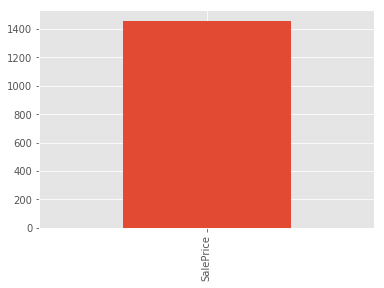

In [31]:
getnullcount()

## 特征工程
- 将一些数值特征转换为类别特征。最好使用LabelEncoder和get_dummies来实现这些功能。

In [32]:
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    data[col] = data[col].astype(str)

In [33]:
# str_col = []
# for i in data.columns:
#     if data[i].dtype =='float64':
#         str_col.append(i)
# print(str_col)

- 现在做一个很长的value映射表。
- 我受到了洞察力的影响，我们应该尽可能多地构建特征并信任模型选择正确的特征。 因此我决定根据一个特征对SalePrice进行分组，并按照平均值和中位数对其进行排序。

In [34]:
data.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])
# data['MSSubClass']

SalePrice                
                     mean    median count
MSSubClass                               
120         200779.080460  192000.0    87
150                   NaN       NaN     0
160         138647.380952  146000.0    63
180         102300.000000   88500.0    10
190         129613.333333  128250.0    30
20          185224.811567  159250.0   536
30           95829.724638   99900.0    69
40          156125.000000  142500.0     4
45          108591.666667  107500.0    12
50          143302.972222  132000.0   144
60          240403.542088  216000.0   297
70          166772.416667  156000.0    60
75          192437.500000  163500.0    16
80          169736.551724  166500.0    58
85          147810.000000  140750.0    20
90          133541.076923  135980.0    52

## 基本会这么搞
- map:
  - {'180' : 1
  '30' : 2   '45' : 2
  '190' : 3, '50' : 3, '90' : 3,
  '85' : 4, '40' : 4, '160' : 4
  '70' : 5, '20' : 5, '75' : 5, '80' : 5, '150' : 5
  '120': 6, '60' : 6}
- 不同的人可能对如何映射这些值有不同的看法，所以请按照你的本能；下面我还在特征前添加一个小“o”，以便保持原始特征能使用get_dummies。

In [35]:
def map_values():
    data["oMSSubClass"] = data.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    data["oMSZoning"] = data.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    data["oNeighborhood"] = data.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    data["oCondition1"] = data.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    data["oBldgType"] = data.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    data["oHouseStyle"] = data.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    data["oExterior1st"] = data.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    data["oMasVnrType"] = data.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    data["oExterQual"] = data.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    data["oFoundation"] = data.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    data["oBsmtQual"] = data.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oBsmtExposure"] = data.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    data["oHeating"] = data.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    data["oHeatingQC"] = data.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oKitchenQual"] = data.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    data["oFunctional"] = data.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    data["oFireplaceQu"] = data.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oGarageType"] = data.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    data["oGarageFinish"] = data.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    data["oPavedDrive"] = data.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    data["oSaleType"] = data.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    data["oSaleCondition"] = data.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                              
    return "Done!"

In [36]:
map_values()

'Done!'

In [37]:
# 
data.drop("LotAreaCut",axis=1,inplace=True)
data.drop(['SalePrice'],axis=1,inplace=True)

## Pipeline
- 接下来我们可以构建一个Pipeline。通过Pipeline可以方便地试验不同的特征组合。
- 标签编码(Label Encoding)三个"Year" 特征。

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Imputer

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [39]:
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        lab = LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        return X

In [40]:
# Apply log1p to the skewed features, then get_dummies.
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

In [41]:
# build pipeline
pipe = Pipeline([
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [42]:
# save the original data for later use
data2 = data.copy()

In [43]:
data_pipe = pipe.fit_transform(data2)

In [44]:
data_pipe.shape

(2917, 405)

In [45]:
data_pipe.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,...,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,6.753438,854,0.0,706.0,0.0,150.0,0.000000,0,2,548.0,...,1,0,1,1,0,0,0,1,0,0
1,7.141245,0,0.0,978.0,0.0,284.0,0.000000,1,2,460.0,...,1,0,1,1,0,0,1,0,0,0
2,6.825460,866,0.0,486.0,0.0,434.0,0.000000,1,2,608.0,...,1,0,1,1,0,0,0,1,0,0
3,6.869014,756,0.0,216.0,0.0,540.0,5.609472,1,1,642.0,...,1,0,1,1,0,1,0,0,0,0
4,7.044033,1053,0.0,655.0,0.0,490.0,0.000000,1,2,836.0,...,1,0,1,1,0,0,0,1,0,0


## 使用robustscaler，因为可能还有其他异常值。

In [46]:
scaler = RobustScaler()

In [47]:
n_train=train.shape[0]

X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

## 特征选择
- 必须承认，上面的特征工程还不够，所以我们需要更多。
- 结合不同的特征通常是一种好方法，但我们不知道应该选择哪些特征。
- 幸运的是有一些模型可以提供特征选择，这里我使用Lasso，但你可以自由选择Ridge，RandomForest或GradientBoostingTree。

In [48]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [49]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=data_pipe.columns)

In [50]:
FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
GrLivArea,0.108870
OverallQual,0.102583
2ndFlrSF,0.074221
YearBuilt,0.068926
1stFlrSF,0.059760
Functional_Typ,0.051862
TotalBsmtSF,0.050261
Neighborhood_Crawfor,0.049942
OverallCond,0.045527
oNeighborhood,0.044311


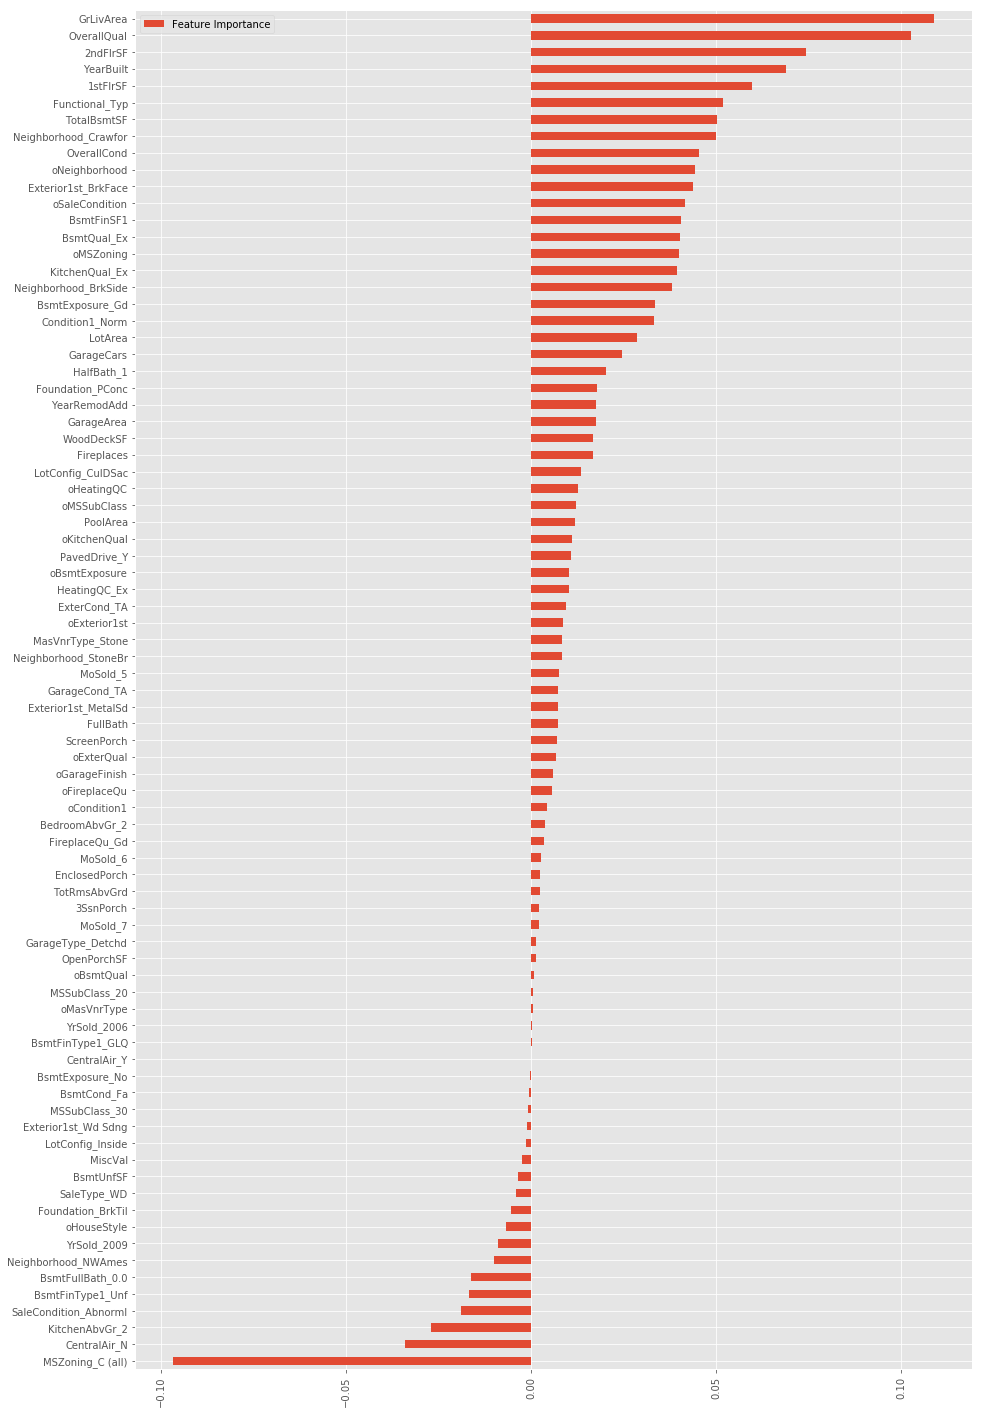

In [51]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

- 根据“特征重要性”图和其他尝试错误，我决定在管道中添加一些特征。

In [54]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
            if self.additional==1:
                X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
                X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]

            else:
                X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
                X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]

                X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
                X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
                X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
                X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
                X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
                X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
                X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
                X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
                X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]

                X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
                X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
                X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
                X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
                X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
                X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]


                X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
                X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
                X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
                X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]


                return X

- 通过使用管道，您可以快速实验不同的功能组合。

In [55]:
pipe = Pipeline([
    ('labenc', labelenc()),
    ('add_feature', add_feature(additional=2)),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

## PCA
- 我的情况，做PCA非常重要。 它让我在排行榜上获得了相对较大的提升。 起初我不相信PCA可以帮助我，但回想起来，可能原因是我构建的特征高度相关，导致多重共线性。 PCA可以去除这些特征。
- 因此，我将在PCA中使用与原始数据大致相同的维度。 由于这里的目标不是减少deminsion。

In [57]:
data2_pipe = pipe.fit_transform(data)

In [58]:
data2_pipe.shape

(2917, 426)

In [60]:
n_train = train.shape[0]
X = data2_pipe[:n_train]
test_X = data2_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

In [61]:
pca = PCA(n_components=410)

In [62]:
X_scaled=pca.fit_transform(X_scaled)
test_X_scaled = pca.transform(test_X_scaled)

In [63]:
X_scaled.shape, test_X_scaled.shape

((1458, 410), (1459, 410))

## 模型训练与评估

In [64]:
# define cross validation strategy
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

### We choose 13 models and use 5-folds cross-calidation to evaluate these models.
Models include:

- LinearRegression
- Ridge
- Lasso
- Random Forrest
- Gradient Boosting Tree
- Support Vector Regression
- Linear Support Vector Regression
- ElasticNet
- Stochastic Gradient Descent
- BayesianRidge
- KernelRidge
- ExtraTreesRegressor
- XgBoost

In [65]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [66]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 1173751260.947357, 808790774.1825
Ridge: 0.117596, 0.0091
Lasso: 0.121474, 0.0060
RF: 0.141625, 0.0079
GBR: 0.123869, 0.0069
SVR: 0.112727, 0.0047
LinSVR: 0.121452, 0.0078
Ela: 0.111113, 0.0059
SGD: 0.151107, 0.0135
Bay: 0.110577, 0.0060
Ker: 0.109276, 0.0055
Extra: 0.138022, 0.0045
Xgb: 0.127241, 0.0068


## 接下来我们做一些超参数调整。 首先定义gridsearch方法。

In [67]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

## Lasso

In [68]:
grid(Lasso()).grid_get(X_scaled,y_log,{'alpha': [0.0004,0.0005,0.0007,0.0009],'max_iter':[10000]})

{'alpha': 0.0005, 'max_iter': 10000} 0.11129660796478764
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.111463        0.001392
1  {'alpha': 0.0005, 'max_iter': 10000}         0.111297        0.001339
2  {'alpha': 0.0007, 'max_iter': 10000}         0.111538        0.001284
3  {'alpha': 0.0009, 'max_iter': 10000}         0.111915        0.001206


In [69]:
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})

{'alpha': 60} 0.11020174961498397
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.110375        0.001268
1  {'alpha': 40}         0.110305        0.001249
2  {'alpha': 45}         0.110258        0.001235
3  {'alpha': 50}         0.110227        0.001223
4  {'alpha': 55}         0.110209        0.001213
5  {'alpha': 60}         0.110202        0.001205
6  {'alpha': 65}         0.110203        0.001198
7  {'alpha': 70}         0.110212        0.001192
8  {'alpha': 80}         0.110247        0.001184
9  {'alpha': 90}         0.110301        0.001178


In [70]:
grid(SVR()).grid_get(X_scaled,y_log,{'C':[11,13,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'C': 13, 'epsilon': 0.009, 'gamma': 0.0004, 'kernel': 'rbf'} 0.10823195916311489
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108661   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108312   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108650   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.108297   
4   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108562   
5   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108248   
6   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108555   
7   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.108232   
8   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108474   
9   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108248   
10  {'C': 15, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108444   
11  {'C': 15, 'epsilon': 0.009

In [71]:
param_grid={'alpha':[0.2,0.3,0.4], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1]}
grid(KernelRidge()).grid_get(X_scaled,y_log,param_grid)

{'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'kernel': 'polynomial'} 0.1082697361476585
                                              params  mean_test_score  \
0  {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.108270   
1  {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.108509   
2  {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.108399   
3  {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.108278   
4  {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.108762   
5  {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.108299   

   std_test_score  
0        0.001209  
1        0.001243  
2        0.001189  
3        0.001210  
4        0.001181  
5        0.001191  


In [72]:
grid(ElasticNet()).grid_get(X_scaled,y_log,{'alpha':[0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3],'max_iter':[10000]})

{'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter': 10000} 0.111171351584536
                                              params  mean_test_score  \
0  {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.114762   
1  {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.114250   
2  {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.112062   
3  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.111278   
4  {'alpha': 0.004, 'l1_ratio': 0.1, 'max_iter': ...         0.111209   
5  {'alpha': 0.004, 'l1_ratio': 0.3, 'max_iter': ...         0.112483   
6  {'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter':...         0.111171   
7  {'alpha': 0.005, 'l1_ratio': 0.1, 'max_iter': ...         0.111192   
8  {'alpha': 0.005, 'l1_ratio': 0.3, 'max_iter': ...         0.112983   

   std_test_score  
0        0.001937  
1        0.001904  
2        0.001596  
3        0.001382  
4        0.001326  
5        0.001160  
6        0.001312  
7        0.001277  
8        0.001159

## 集成方法
### Weight Average

In [73]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [74]:
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

In [75]:
# assign weights based on their gridsearch score
w1 = 0.02
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.03
w6 = 0.2
# LR: 1173751260.947357, 808790774.1825
# Ridge: 0.117596, 0.0091
# Lasso: 0.121474, 0.0060
# RF: 0.141625, 0.0079
# GBR: 0.123869, 0.0069
# SVR: 0.112727, 0.0047
# LinSVR: 0.121452, 0.0078
# Ela: 0.111113, 0.0059
# SGD: 0.151107, 0.0135
# Bay: 0.110577, 0.0060
# Ker: 0.109276, 0.0055
# Extra: 0.138022, 0.0045
# Xgb: 0.127241, 0.0068

In [76]:
weight_avg = AverageWeight(mod = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])

In [77]:
score = rmse_cv(weight_avg,X_scaled,y_log)
print(score.mean())

0.10768459878025735


- 但如果我们只平均两个最佳模型，我们会获得更好的交叉验证分数。

In [78]:
weight_avg = AverageWeight(mod = [svr,ker],weight=[0.5,0.5])

In [79]:
score = rmse_cv(weight_avg,X_scaled,y_log)
print(score.mean())

0.10668349587194903


## Stacking
- 除了正常的堆叠，我还添加了“get_oof”方法，因为稍后我将结合堆叠和原始功能生成的功能。

In [80]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [81]:
# 我们先试试吧！ 运行此方法有点慢，因为该过程非常简单。

In [82]:
# must do imputer first, otherwise stacking won't work, and i don't know why.
a = Imputer().fit_transform(X_scaled)
b = Imputer().fit_transform(y_log.values.reshape(-1,1)).ravel()

In [83]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

In [84]:
score = rmse_cv(stack_model,a,b)
print(score.mean())

0.10657571156285586


- 接下来，我们提取堆叠生成的特征，然后将它们与原始特征结合起来。

In [85]:
X_train_stack, X_test_stack = stack_model.get_oof(a,b,test_X_scaled)

In [86]:
X_train_stack.shape, a.shape

((1458, 6), (1458, 410))

In [87]:
X_train_add = np.hstack((a,X_train_stack))

In [88]:
X_test_add = np.hstack((test_X_scaled,X_test_stack))

In [89]:
X_train_add.shape, X_test_add.shape

((1458, 416), (1459, 416))

In [90]:
score = rmse_cv(stack_model,X_train_add,b)
print(score.mean())

0.10182468342790936


- 您可以在获得“X_train_stack”后对元模型进行参数调整，或者在与原始功能组合后进行参数调整。 但这也是很多工作！

In [92]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

In [93]:
stack_model.fit(a,b)

stacking(meta_model=KernelRidge(alpha=0.2, coef0=0.8, degree=3, gamma=None, kernel='polynomial',
      kernel_params=None),
     mod=[Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=No...True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)])

In [94]:
pred = np.exp(stack_model.predict(test_X_scaled))

In [95]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result.to_csv("data/submission1.csv",index=False)